In [1]:
msg = "Hello World"
print(msg)

Hello World


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load dataset
df = pd.read_csv("./Suicide_Detection.csv")  

data=df.copy()
# Display basic info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [5]:
# Check for missing values
print("Missing values per column:\n", data.isnull().sum())
# Drop rows with missing text data
data.dropna(subset=['text'], inplace=True)

Missing values per column:
 Unnamed: 0    0
text          0
class         0
dtype: int64


Exploratory Data Analysis (EDA)

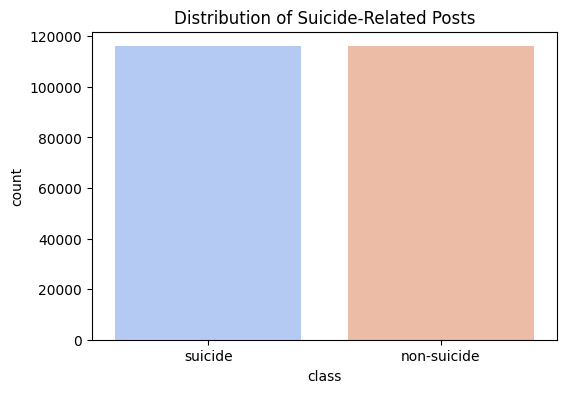

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=data, palette="coolwarm")
plt.title("Distribution of Suicide-Related Posts")
plt.show()

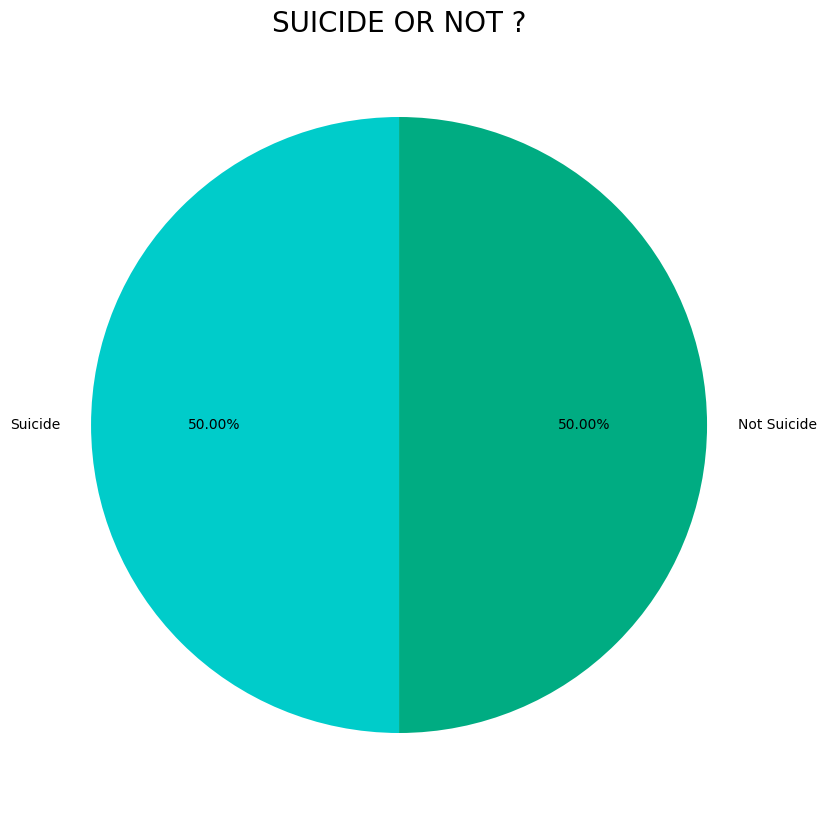

In [9]:
plt.figure(figsize=(12,10))
plt.pie(data['class'].value_counts(),startangle=90,colors=['#00ccca','#00ac82'],
        autopct='%0.2f%%',labels=['Suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

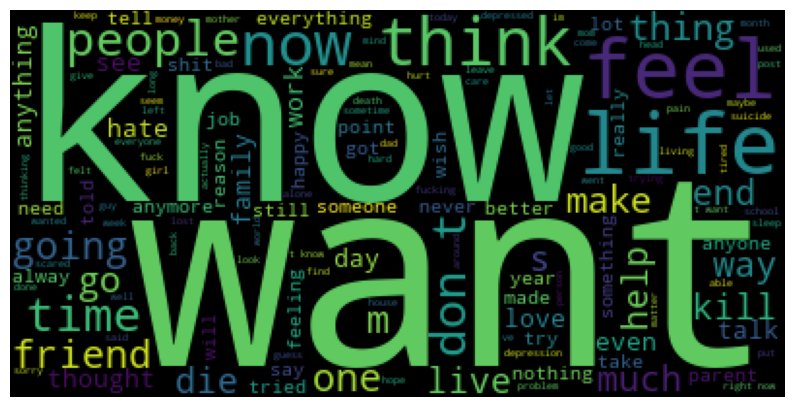

In [7]:
suicide=data[data['class']=='suicide']['text']
xsuicide=data[data['class']=='non-suicide']['text']

def display_cloud(data):
    plt.subplots(figsize=(10,10))
    wc = wordcloud.WordCloud(
                   background_color="black",
                   colormap='viridis',
                   max_words=1000,
                   random_state=24)
    plt.imshow(wc.generate(' '.join(data)))
    plt.axis('off')
    plt.show()

display_cloud(suicide)

In [13]:
# Convert target labels into numeric format
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])  # Encode "suicide" (1) and "non-suicide" (0)
# Save label encoder classes for later use
with open('label_encoder_classes.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_, f)

In [14]:
# Text Processing using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_text = vectorizer.fit_transform(data['text'])
# Save the vectorizer for later use
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_text, data['class'], test_size=0.2, random_state=42)

In [10]:
# Standardize feature set
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression Model

In [12]:
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Train only Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, lr_preds)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_test, lr_preds))

# Save the model
print("Saving Logistic Regression model...")
with open('suicide_detection_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Verify all files were saved
import os
required_files = ['suicide_detection_model.pkl', 'tfidf_vectorizer.pkl', 'scaler.pkl', 'label_encoder_classes.pkl']
for file in required_files:
    if os.path.exists(file):
        print(f"✓ {file} saved successfully")
    else:
        print(f"✗ {file} NOT found")

print("\nModel training and saving complete!")

Training Logistic Regression model...
Logistic Regression Accuracy: 0.9314
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23287
           1       0.94      0.92      0.93     23128

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Saving Logistic Regression model...
✓ suicide_detection_model.pkl saved successfully
✗ tfidf_vectorizer.pkl NOT found
✓ scaler.pkl saved successfully
✗ label_encoder_classes.pkl NOT found

Model training and saving complete!


Random Forest Model

In [15]:
rf_model = RandomForestClassifier(n_estimators=60, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     23287
           1       0.89      0.92      0.90     23128

    accuracy                           0.90     46415
   macro avg       0.90      0.90      0.90     46415
weighted avg       0.90      0.90      0.90     46415



In [14]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     23287
           1       0.93      0.89      0.91     23128

    accuracy                           0.91     46415
   macro avg       0.91      0.91      0.91     46415
weighted avg       0.91      0.91      0.91     46415



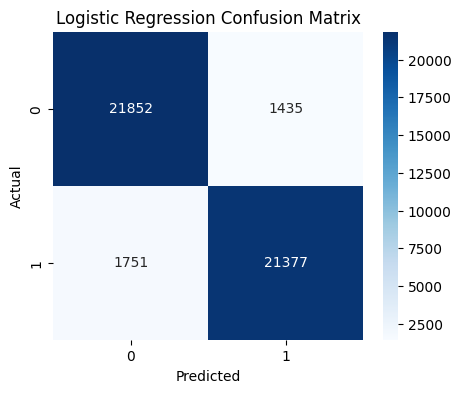

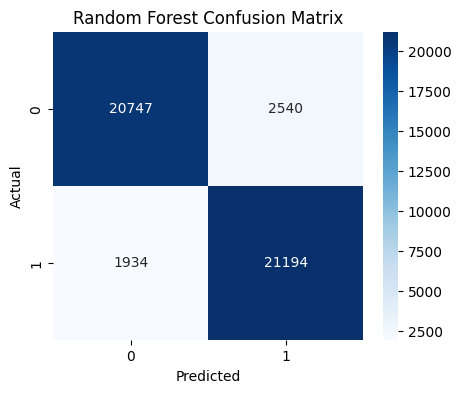

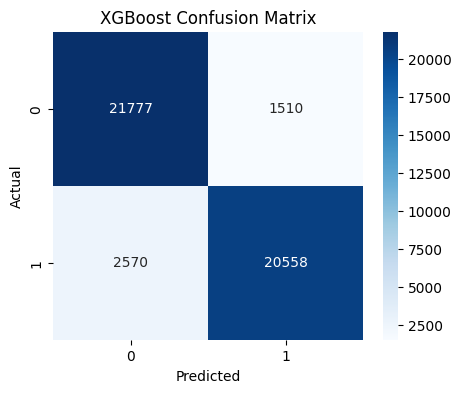

In [16]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, lr_preds, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, rf_preds, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, xgb_preds, "XGBoost Confusion Matrix")